X-Ray interaction with matter phantom
Xray spectra at different energies generated using python module xpecgen ; it is set for a Tungston target, 22 mm added filtration 100 cm air gap.
Detail of xpecgen are available at https://github.com/Dih5/xpecgen


In [114]:
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_cells_below()'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [116]:
import time
import csv
from csv import reader, writer
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm
from IPython.display import clear_output

In [18]:
%reload_ext watermark

# python, ipython, packages, and machine characteristics
%watermark -v -m -p time,csv,pandas,random,numpy,matplotlib.pyplot,PIL,IPython.display,watermark

# date
print (" ")
%watermark -u -n -t -z 

CPython 3.6.10
IPython 6.4.0

time unknown
csv 1.0
pandas 0.23.0
random unknown
numpy 1.14.3
matplotlib.pyplot 3.0.2
PIL 5.4.1
IPython.display 6.4.0
watermark 2.0.2

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1160.49.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
 
last updated: Sat Jan 01 2022 11:42:15 CET


In [118]:
def read_data():
    global mu_liver
    mu_liver = pd.read_csv("mu_values_tissues/mu_liver_complete.csv", header=0)
    global mu_fat
    mu_fat = pd.read_csv("mu_values_tissues/mu_fat_complete.csv", header=0)
    global mu_air
    mu_air = pd.read_csv("mu_values_tissues/mu_air_complete.csv", header=0)
    global KV_quant_factor
    KV_quant_factor = pd.read_csv("KV_mAs_5_PercentRule/data_KV_mAs.csv", header = 0)
    

In [119]:
read_data()

In [120]:
def spectra(x):
    keV=x
    with open('spectra/'+str(keV)+"_spectrum.csv") as f, open('destination.csv', 'w') as fw: 
        writer(fw, delimiter=',').writerows(zip(*reader(f, delimiter=',')))
    global spectral_data
    spectral_data = pd.read_csv("destination.csv", header=None)
    #return (spectral_data)

    

Sample the spectrum. Choose KeV values at random between min and max photon energies (column one) and choose random values for intensity min to max


In [121]:
def spectral_limits():
    global maxInt
    maxInt=max(spectral_data[1])
    maxInt
    global maxKeV
    maxKeV=max(spectral_data[0])
    maxKeV
    

In [122]:
#Here is the Monte Carlo sampling".

def monte_carlo_sample(mAs, maxKev):
    factor=(spectral_data.shape[0]-1)/maxKeV
    global mc_spectrum
    mc_spectrum = pd.DataFrame([])
    i=0
    while i < 10*mAs:
        randX= np.random.uniform(low=0.0,high=maxKeV,size=1)
        randY= np.random.uniform(low=0.0,high=maxInt,size=1)
        if float(randY)<spectral_data[1][round(factor*float(randX))] and float(randY)>0:
            i=i+1
            temp=pd.DataFrame([round(float(randX))])
            mc_spectrum=pd.concat([mc_spectrum,temp])
    mc_spectrum = mc_spectrum.rename(columns={0 :'keV'})
    return(mc_spectrum)


In [123]:
def get_spectra_dependent_mu():
    global spect_dependent_mu
    spect_dependent_mu=pd.merge(mc_spectrum,mu_fat,on='keV',how='left')

get_spectra_dependent_mu() 

In [124]:
#spectral_data

In [125]:
spect_dependent_mu['mu'].mean()

0.38776750000000015

In [126]:
def create_images(mAs,maxKeV):
    mAs_factor = KV_quant_factor.loc[KV_quant_factor['KV']== maxKeV]['mAs']
    mAs = mAs * mAs_factor.item()
    print(mAs_factor.item())
    global total_nr_photons
    total_nr_photons = 10*100*mAs
    
    global image_fat
    image_fat = np.zeros((10,10))
    for  i in range (0,10,1):
        for j in range (0,10,1):
            monte_carlo_sample(mAs, maxKeV)
            spect_dependent_mu=pd.merge(mc_spectrum,mu_fat,on='keV',how='left')
            image_fat[i,j]= np.power(10,(-1*spect_dependent_mu['mu'].mean()))
        print("working on pixel row " + str(i+1)  +" out of 10 for image 1 of 3     ", end='\r')
        #time.sleep(1)
    print("",end='\n')
    #image_fat

    global image_liver
    image_liver = np.zeros((10,10))
    for  i in range (0,10,1):
        for j in range (0,10,1):
            monte_carlo_sample(mAs, maxKeV)
            spect_dependent_mu=pd.merge(mc_spectrum,mu_liver,on='keV',how='left')
            image_liver[i,j]= np.power(10,(-1*spect_dependent_mu['mu'].mean()))
        print("working on pixel row " + str(i+1)  +" out of 10 for image 2 of 3     ", end='\r')
        #time.sleep(1)
    print("",end='\n')
    #image_liver

    global image_air
    image_air = np.zeros((10,10))
    for  i in range (0,10,1):
        for j in range (0,10,1):
            monte_carlo_sample(mAs, maxKeV)
            spect_dependent_mu=pd.merge(mc_spectrum,mu_air,on='keV',how='left')
            image_air[i,j]= np.power(10,(-1*spect_dependent_mu['mu'].mean()))
        print("working on pixel row " + str(i+1)  +" out of 10 for image 3 of 3     ", end='\r')
    print("",end='\n')
    time.sleep(1)
    clear_output()    

In [127]:
#df.loc[df['column_name'] == some_value]
#test=KV_quant_factor.loc[KV_quant_factor['KV']==41]['mAs']
#test[0]
KV_quant_factor
#df.loc[df['col1'] == value]
test=KV_quant_factor.loc[KV_quant_factor['KV'] == 46]['mAs']
test.item()

2.1202964411326084

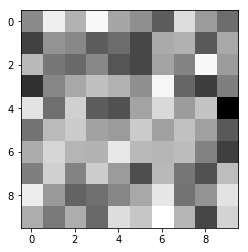

In [128]:
fig = plt.figure
plt.imshow(image_air, cmap='gray')
plt.show()

In [129]:
def display_images():
    fig = plt.figure()
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(image_liver, cmap='gray_r',vmin=0,vmax=1)
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(image_fat, cmap='gray_r',vmin=0,vmax=1)
    ax3 = fig.add_subplot(1,3,3)
    ax3.axes.set_xlabel("Air")
    ax3.imshow(image_air, cmap='gray_r',vmin=0,vmax=1)

    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax1.axes.set_title('Liver')

    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.axes.set_title('Fat')

    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax3.axes.set_title('Air')

    liver_mean = image_liver.mean()
    liver_std = image_liver.std()
    liver_snr = 10*np.log10(liver_mean/liver_std) # in db
    fat_mean = image_fat.mean()
    fat_std = image_fat.std()
    fat_snr = 10*np.log10(fat_mean/fat_std) # in db
    air_mean = image_air.mean()
    air_std = image_air.std()
    air_snr = 10*np.log10(air_mean/air_std) # in db


    print("Liver; Mean pixel value,",liver_mean)
    print("Liver; SNR, ", liver_snr, "db")
    print("Total number of photons reaching detector ", str(int(total_nr_photons*liver_mean)), end='\n\n')
    print("Fat; Mean pixel value,",fat_mean)
    print("Fat; SNR, ", fat_snr, "db")
    print("Total number of photons reaching detector ", str(int(total_nr_photons*fat_mean)), end='\n\n')
    print("Air; Mean pixel value,",air_mean)
    print("Air; SNR, ", air_snr, "db")
    print("Total number of photons reaching detector ", str(int(total_nr_photons*air_mean)), end='\n\n')
    
    contrast = np.log10(fat_mean/liver_mean)
    print ("Fat to liver contrast,", contrast)




In [130]:
def phantom(mAs, KVp):
    if mAs <1:
        raise ValueError("mAs should be an integer between 1 and 10 inclusive")
    #if mAs >10:
    #    raise ValueError("mAs should be an integer between 1 and 10 inclusive")
    if KVp < 40:
        raise ValueError("KVp should be an integer between 40 and 120 inclusive")
    if KVp > 120:
        raise ValueError("KVp should be an integer between 40 and 120 inclusive")
    #mAs=100
    maxKeV=KVp
    #mAs=100
    #load_packages()
    read_data()
    spectra(KVp)
    spectral_limits()
    create_images(mAs,KVp)
    display_images()
    

Liver; Mean pixel value, 0.20962735817457814
Liver; SNR,  6.868731059679187 db
Total number of photons reaching detector  838

Fat; Mean pixel value, 0.37806574003665494
Fat; SNR,  10.945916271351624 db
Total number of photons reaching detector  1512

Air; Mean pixel value, 0.998253067777554
Air; SNR,  36.54825639197069 db
Total number of photons reaching detector  3993

Fat to liver contrast, 0.25611936260773566


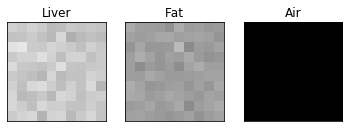

In [131]:
phantom(4,40)

Liver; Mean pixel value, 0.20469488995064464
Liver; SNR,  8.463148193831376 db
Total number of photons reaching detector  1637

Fat; Mean pixel value, 0.3776278066469016
Fat; SNR,  11.621773950037447 db
Total number of photons reaching detector  3021

Air; Mean pixel value, 0.9982345939216464
Air; SNR,  37.62483995322307 db
Total number of photons reaching detector  7985

Fat to liver contrast, 0.2659569651319983


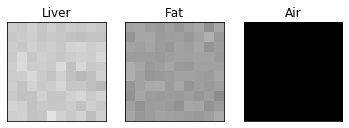

In [132]:
phantom(8,40)

Liver; Mean pixel value, 0.26627769755882397
Liver; SNR,  12.120274241892481 db
Total number of photons reaching detector  7072

Fat; Mean pixel value, 0.43011897243733577
Fat; SNR,  15.120038614816151 db
Total number of photons reaching detector  11423

Air; Mean pixel value, 0.9985450884210517
Air; SNR,  40.8362904218791 db
Total number of photons reaching detector  26520

Fat to liver contrast, 0.20825380654185993


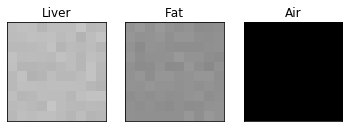

In [134]:
phantom(8,50)

Liver; Mean pixel value, 0.19921161923846475
Liver; SNR,  4.3866526558185654 db
Total number of photons reaching detector  199

Fat; Mean pixel value, 0.3880954837409118
Fat; SNR,  7.56188394574679 db
Total number of photons reaching detector  388

Air; Mean pixel value, 0.9982347299183744
Air; SNR,  34.04053803131663 db
Total number of photons reaching detector  998

Fat to liver contrast, 0.28962392336016435


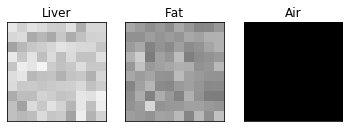

In [135]:
phantom(1,40)

In [6]:
import watermark
import wget